### This code is used to extract and analyze the spectrum in the line of sight from TNG100-3 data
created by Shulan Yan in Jul.18.2021 \
contact me : yansl {at} stu.xmu.edu.cn

### steps
> 1. Extract the spectrum
> 2. Fit the spectrum
> 3. Analyze the results

The total data is in the [TNG100-3 webpage](https://www.tng-project.org/data/downloads/TNG100-3/)

**At first,it is necessary to write down some useful equations.**
>$b_T=\sqrt{\frac{2kT}{A\ m_p}}=1.290\times10^4\sqrt{\frac{T}{A}}\ \ cm\ s^{-1}$( A is the atomic weight , for Hydrogen , A=1. T is the gas temperature )

>$\mu = \frac{4}{ 1 + 3 X_H + 4 X_H\ x_e } * m_p$

>$T = (\gamma - 1) * u / k_B * \frac{\rm{UnitEnergy}}{\rm{UnitMass}} * \mu$

>`UnitEnergy = UnitMass * UnitLength^2 / UnitTime^2`

>$\gamma = \frac{5}{3}$

>$X_H=0.76$

>$\tau(\nu)=\frac{\sigma_0}{\sqrt{\pi}\nu_0}\frac{c}{b_T}\int_{0}^{z_0}n_i(z)\ \exp\{-{[(1+z)\frac{\nu}{\nu_0}-1+\frac{v_{pec}}{c}]}^2\frac{c^2}{{b_T}^2}\}\frac{dl}{dz}dz$

>$v=H_0\times D_r$

>$n_{HI}=\frac{\rho}{u}$ ($u=1.66\times10^{-24}g$)

>$M_{\bigodot}=1.989\times10^{33}g$

>$H_0=67.74\ km\ s^{-1}\ Mpc^{-1} = 67.74\times3\times10^{-24}\ km\ s^{-1}\ cm^{-1}$

In TNG , the temperature should be calculated from its' `InternalEnergy` and `ElectronAbundance`.

The reference webpage is in the [calculation of temperature](https://www.tng-project.org/data/docs/faq/#gen5).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py,csv,sys,math,os
from scipy.stats import binned_statistic_2d
from scipy import interpolate
from lmfit import Model
import illustris_python as il
from matplotlib.pyplot import MultipleLocator

**At first , we need some important parameters of `TNG100-3`**

In [3]:
h = 0.6774 # hubble constant 'little h' in units of [100 km/s/Mpc]
L_box1 = 110.7 # Mpc
L_box2 = 75 # Mpc/h
Omega_m = 0.3089
Omega_dm = 0.6911
Omega_b = 0.0486

X_H = 0.76
m_p = 1.67*10**(-24)
gamma = 5/3
k_B = 1.38*10**(-16) # erg K^-1

f_lya = 0.416
e = 4.8e-10
m_e = 9e-28 
pi = np.pi
c = 3e10  # cm/s
sigma = f_lya*(pi*e**2)/(m_e*c)

### Now , the program is Begin !

**Get the header message**

In [4]:
basepath = 'tng100-3'

In [5]:
header = il.groupcat.loadHeader(basepath, 99)
header.keys()

dict_keys(['BoxSize', 'FlagDoubleprecision', 'Git_commit', 'Git_date', 'HubbleParam', 'Ngroups_ThisFile', 'Ngroups_Total', 'Nids_ThisFile', 'Nids_Total', 'Nsubgroups_ThisFile', 'Nsubgroups_Total', 'NumFiles', 'Omega0', 'OmegaLambda', 'Redshift', 'Time'])

In [6]:
header

{'BoxSize': 75000.0,
 'FlagDoubleprecision': 0,
 'Git_commit': b'd203ec8b07c7e2bdda5f608aa0babea46d603699',
 'Git_date': b'Thu Apr 7 14:14:27 2016 +0200',
 'HubbleParam': 0.6774,
 'Ngroups_ThisFile': 15,
 'Ngroups_Total': 124773,
 'Nids_ThisFile': 10358237,
 'Nids_Total': 72200157,
 'Nsubgroups_ThisFile': 3870,
 'Nsubgroups_Total': 118820,
 'NumFiles': 7,
 'Omega0': 0.3089,
 'OmegaLambda': 0.6911,
 'Redshift': 2.220446049250313e-16,
 'Time': 0.9999999999999998}

In [7]:
scale_factor = 1/(1+header['Redshift'])

**Extract the data we need** \
The more details of extract gas, star, dark matter and other data sets are in [this webpage from TNG](https://www.tng-project.org/data/docs/scripts/)\
Now , we can extract the data of **gas coordinates** and **masses** as an example

In [12]:
fields = ['Coordinates','Masses']
Gas_example = il.snapshot.loadSubset(basepath, 99, 'gas', fields)

In [13]:
Gas_example.keys()

dict_keys(['count', 'Coordinates', 'Masses'])

In [14]:
Gas_example['count']

88935326

In [15]:
Gas_example['Coordinates'].shape

(88935326, 3)

In [18]:
Gas_example['Masses'].shape

(88935326,)

**The function below can help us to calculate the temperature.**

It is from the jupyter lab of TNG data access.

The method of this function is in the webpage : https://www.tng-project.org/data/docs/faq/#gen5

In [10]:
def utherm_ne_to_temp(utherm, nelec):
    """ Convert the InternalEnergy and ElectronAbundance of gas cells to temperature in [log K]. """
    hydrogen_massfrac = 0.76 # approximate
    mass_proton = 1.672622e-24 # cgs
    gamma = 5/3
    boltzmann = 1.380650e-16 # cgs (erg/K)

    # unit system
    UnitLength_in_cm = 3.085678e21   # 1.0 kpc
    UnitMass_in_g = 1.989e43 # 1.0e10 solar masses
    UnitVelocity_in_cm_per_s = 1.0e5 # 1 km/sec

    UnitTime_in_s = UnitLength_in_cm / UnitVelocity_in_cm_per_s
    UnitEnergy_in_cgs = UnitMass_in_g * UnitLength_in_cm**2.0 / UnitTime_in_s**2.0

    # calculate mean molecular weight
    meanmolwt = 4.0/(1.0 + 3.0 * hydrogen_massfrac + 4.0* hydrogen_massfrac * nelec)
    meanmolwt *= mass_proton

    # calculate temperature ( unit : K )
    temp = utherm * (gamma-1.0) / boltzmann * UnitEnergy_in_cgs / UnitMass_in_g * meanmolwt
    #temp = np.log10(temp)

    return temp.astype('float32')

In [20]:
fields = ['InternalEnergy','ElectronAbundance']
temp_para = il.snapshot.loadSubset(basepath, 99, 'gas', fields)

In [21]:
temp = utherm_ne_to_temp(temp_para['InternalEnergy'], temp_para['ElectronAbundance'])

In [22]:
temp[0]

34685400.0

### Figure of HI projection

We can use these to create the simplest type of visualization: a (weighted) 2D histogram, showing the large-scale structure of the box. \
Or we can plot the projection figure through z-dirrection.

Our `grid` now contains the sum of $\rho_{HI}$ per pixel (projected along the line of sight, through the whole box depth).

In [28]:
fields = ['Coordinates','Density','GFM_Metals','NeutralHydrogenAbundance']
gas = il.snapshot.loadSubset(basepath, 99, 'gas', fields)

In [31]:
coord1 = gas['Coordinates'][:,0]
coord2 = gas['Coordinates'][:,1]
weights = gas["Density"]*gas["GFM_Metals"][:,0]*gas["NeutralHydrogenAbundance"]
nPixels = [455,455]
minMax = [0, header['BoxSize']]
grid, _, _, _ = binned_statistic_2d(coord1, coord2, weights, 'sum', bins=nPixels, range=[minMax,minMax])

pxSize = header['BoxSize'] / nPixels[0] # code units
pxSize_kpc = pxSize * header['Time'] / header['HubbleParam']
pxArea = pxSize_kpc**2
grid_HI_density = np.log10(grid * 1e10 / header['HubbleParam'] / pxArea)

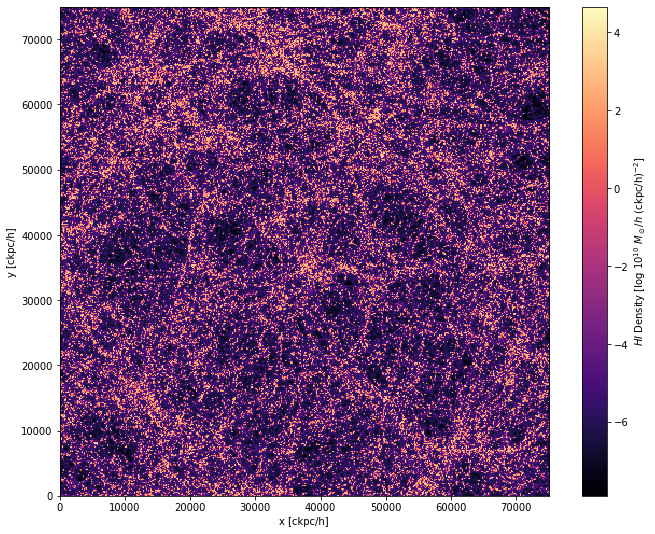

In [36]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
extent = [0, header['BoxSize'], 0, header['BoxSize']]
plt.imshow(grid_HI_density, extent=extent, cmap='magma',aspect=nPixels[1]/nPixels[0])
ax.autoscale(False)
ax.set_xlabel('x [ckpc/h]')
ax.set_ylabel('y [ckpc/h]')
plt.colorbar(label='$HI$ Density [log $10^{10}\ M_\odot/h$ (ckpc/h)$^{-2}$]');

### Spectrum in one line of sight

It is not possible to choose a true 2D line in one direction , so we need choose a cubic with a small area . \
To comfirm the size of the area , I referenced the [resolution of COS](https://hst-docs.stsci.edu/cosihb/chapter-1-an-introduction-to-cos/1-3-cos-quick-reference-guide). Then we got the angle resolution with the value of **2.5 arcsec**. we need convert this value to the size of distance with the unit of kpc .\
We can suppose that the distance of IGM object is $500\ kpc$ from us . Using equation $r=d\times tan(\theta)$ , we get the size with the value of $6\times 10^{-3}\ kpc$.\
With the **coordinates and volumes** of gas clouds ,  we can get the specific clouds which cross the line of sight . After that , we get the pseudo spectrum.

#### The parameter we need:
>**Coordiantes , Masses , Density , Velocities , GFM_Metals , NeutralHydrogenAbundance , InternalEnergy , ElectronAbundance**

In [8]:
fields = ['Coordinates', 'Velocities', 'Masses', 'InternalEnergy',
          'Density','ElectronAbundance','GFM_Metals','NeutralHydrogenAbundance']
gas = il.snapshot.loadSubset(basepath, 99, 'gas', fields)

In [11]:
loc_center = [100,100] # x location , y location
dr = 0.006*h
z = []
b_t = []
dens = []
vel_z = []
coordinate = []

for j in range(gas['count']):
    gas_volume = gas['Masses'][j]/gas['Density'][j]
    gas_scale = (gas_volume*3/(4*pi))**(1/3)
    if math.hypot(gas['Coordinates'][j][0]-loc_center[0] , gas['Coordinates'][j][1]-loc_center[1])<=(gas_scale+dr):
            z.append(gas['Coordinates'][j][2])
            dens.append(gas['Density'][j]*gas['GFM_Metals'][j][0]*gas['NeutralHydrogenAbundance'][j])
            b_t.append(1.29e4*utherm_ne_to_temp(gas['InternalEnergy'][j],gas['ElectronAbundance'][j])**0.5)
            vel_z.append(gas['Velocities'][j][2])

**Another way to read the data with minimum memory**

In [20]:
snapPath = basepath + '/snapdir_' + str(99).zfill(3) + '/'
snaps = os.listdir(snapPath)
num_part = []
num_total = 0
for i in range(len(snaps)):
    filepath = snapPath + 'snap_099.%i.hdf5' % i
    if not os.path.isfile(filepath): 
        continue
    f = h5py.File(filepath, 'r')
    if not num_total:
        num_total = dict(f['Header'].attrs.items())['NumPart_Total'][0]
    num_part.append(dict(f['Header'].attrs.items())['NumPart_ThisFile'][0])
    f.close()

In [21]:
## Total numbers of gas cells
num_total

88935326

In [22]:
subsetpara = {'snapOffsets':np.array([[0]]),'lenType':np.array([0]),'offsetType':np.array([0])}

In [25]:
fields = ['Coordinates', 'Masses', 'Density']
loc_center = [100,100]

b_t = []
density = []
velocity = []
coordinate = []
GFM_metals, h1abundances = [],[]

for j in range(len(num_part)):        
    subsetpara['lenType'] = np.array([num_part[j]])
    subsetpara['snapOffsets'] = np.array([np.zeros(j+1,dtype=int)])
    gas = il.snapshot.loadSubset(basepath, 99, 'gas', fields, subset = subsetpara)
    index = []
    for k in range(gas['count']):
        gas_volume = gas['Masses'][k]/gas['Density'][k]
        gas_scale = (gas_volume*3/(4*pi))**(1/3)
        if math.hypot(gas['Coordinates'][k][0]-loc_center[0] , gas['Coordinates'][k][1]-loc_center[1])<=(gas_scale+dr): 
            index.append(k)
            coordinate.append(gas['Coordinates'][k])
    del(gas)
    
    densities = il.snapshot.loadSubset(basepath, 99, 'gas', 'Density', subset = subsetpara)[index]
    density = np.array(list(density) + list(densities))
    del(densities)

    velocities = il.snapshot.loadSubset(basepath, 99, 'gas', 'Velocities', subset = subsetpara)[index]
    velocity = np.array(list(velocity) + list(velocities))
    del(velocities)

    fields2 = ['InternalEnergy', 'ElectronAbundance']
    gas = il.snapshot.loadSubset(basepath, 99, 'gas', fields2, subset = subsetpara)
    temp = utherm_ne_to_temp(gas['InternalEnergy'][index], gas['ElectronAbundance'][index])
    b_t = np.array(list(b_t) + list(1.29e4*temp**0.5))
    del(gas)

    fields3 = ['GFM_Metals','NeutralHydrogenAbundance']
    gas_metals = il.snapshot.loadSubset(basepath, 99, 'gas',fields3, mdi = [0,None], subset = subsetpara)
    GFM_metals = np.array(list(GFM_metals) + list(gas_metals['GFM_Metals'][index]))
    h1abundances = np.array(list(h1abundances) + list(gas_metals['NeutralHydrogenAbundance'][index]))
    del(gas_metals)

In [26]:
coordinate = np.array(coordinate)
z = coordinate[:,2]
vel_z = velocity[:,2]
dens = density*GFM_metals*h1abundances

-----

In [12]:
def sortdata(a,b):
    data = []
    for i in range(len(a)):
        raw_data = [a[i],b[i]]
        data.append(raw_data)
    data.sort()
    data_new = np.array(data)
    return data_new[:,0] , data_new[:,1]

In [27]:
### sort the data
_,vel_z = sortdata(z,vel_z)
_,b_t = sortdata(z,b_t)
_,dens = sortdata(z,dens)
z.sort()

the mass of one hydrogen atom is $1.66\ \times\ 10^{-24}\ g$, we can get the **number density** from the mass density: **$$n=\frac{\rho}{u}$$**

In [28]:
numdens = np.array(dens)*(0.338e-21)/(1.66e-24)

### calculate the optical depth

Use the equation of **Fang2002**

### $\tau(\nu)=\frac{\sigma_0}{\sqrt{\pi}\nu_0}\frac{c}{b_T}\int_{0}^{z_0}n_i(z)\ \exp\{-{[(1+z)\frac{\nu}{\nu_0}-1+\frac{v_{pec}}{c}]}^2\frac{c^2}{{b_T}^2}\}\frac{dl}{dz}dz$

### $\frac{dl}{dz} = \frac{c}{H_0} = \frac{3\times10^5(km\ s^{-1})}{(67.74\times3\times10^{-24}\ km\ s^{-1}\ cm^{-1})}$

In [15]:
wave_lya = 1.216e-5 #cm

In [16]:
def gettau():
    dz = 0.025/455
    tau = []
    wave = []
    redshift = ((max(z)-min(z))/10)/3e5

    for i in range(455):
        wave1 = wave_lya*(1+i*dz)
        Constant = sigma/(pi**0.5)*wave_lya/c
        value = 0
        for j in range(len(z)):
            Dens = numdens[j]
            z1 = (z[j]/10)/(3e5)
            v_pec = vel_z[j]/np.sqrt(scale_factor)
            exp0 = -(wave1/(wave_lya*(1+z1)*(1+v_pec/3e5))-1)**2*(c/b_t[j])**2
            value1 = c/b_t[j]*Dens*np.e**(exp0)*3e5/67.74*3e24
            value = value + value1*redshift/len(z)
        tau.append(Constant*value)
        wave.append(wave1*1e8)
    return np.array(wave),np.array(tau)

In [29]:
wavelength , optical_depth = gettau()

In [30]:
flux = np.e**(-optical_depth)

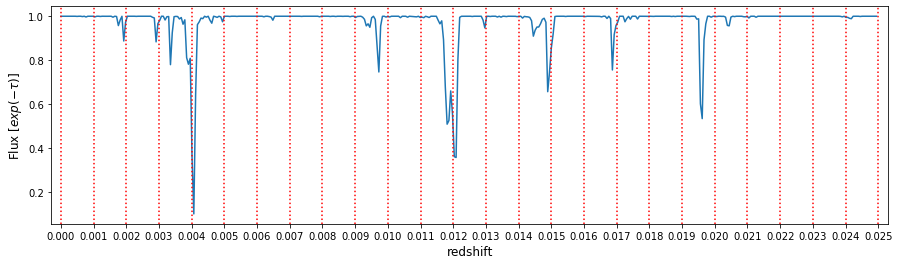

In [31]:
ax = plt.figure(figsize = (15,4))
plt.plot(wavelength*1e-8/wave_lya-1,flux)
for i in range(26):
    plt.axvline(x = i*0.001, linestyle=':', color='red')
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.001))
ax.set_xlim(-0.0003,0.0253)
ax.set_xlabel('redshift',size = 12)
ax.set_ylabel('Flux [$exp(-\\tau)$]',size=12)
# plt.savefig('spec_100_100.jpg')
plt.show()

**save the data of spectrum**

In [33]:
ii = 0
savepath = 'data/spectrum/'
filename = savepath + 'spectrum_%i.csv' %ii
spec_file=pd.DataFrame(columns=[],data=[])
spec_file.to_csv(filename)
with open(filename,'w',encoding='utf-8') as file:
    file_writer = csv.writer(file)
    file_writer.writerow(['wave','flux'])
    file_writer.writerows(zip(wavelength,flux))
file.close()

**Test the saving result**

In [41]:
specdata = pd.read_csv(filename)
specdata.keys()

Index(['wave', 'flux'], dtype='object')

In [37]:
ww = specdata['wave']
ff = specdata['flux']

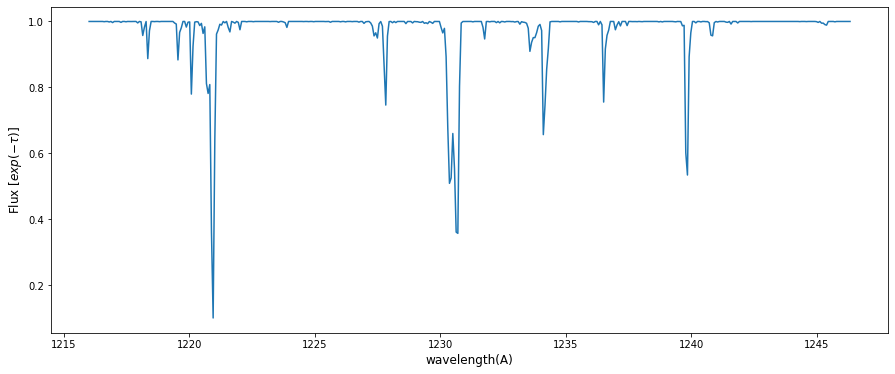

In [40]:
ax = plt.figure(figsize = (15,6))
plt.plot(ww,ff)
ax = plt.gca()
ax.set_xlabel('wavelength(A)',size = 12)
ax.set_ylabel('Flux [$exp(-\\tau)$]',size=12)
plt.show()

### Fit the spectrum
### Steps
> 1. Smooth the spectrum
> 2. Find the possible place of absorption line
> 3. Fit the spectrum use Voigt-profile

In [42]:
def Abvoigt(x, lam, bpar, logn, z, fosc, gam):

    '''
    my voigt profile model
    '''
    x = np.array(x, dtype='float64')
    wave = x
    b = bpar*1e5
    C_a = np.sqrt(np.pi)*e**2*fosc*lam*1.e-8/m_e/c/b
    a = lam*1.e-8*gam/(4.*np.pi*b)
    dl_D = b/c*lam
    x = x/(z+1.)
    u = (x - lam)/dl_D + 0.00001
    
    #Voigt Profile Approximation from T. Tepper-Garcia 2006, 2007

    P = u**2
    H0 = np.exp(-u**2)
    Q = 1.5/u**2
    H =  H0 - a/np.sqrt(np.pi)/P * (H0*H0*(4.*P*P + 7.*P + 4. + Q) - Q - 1)  #跟莫厚俊书本711页（16.106）类似
    tau = np.float64(C_a) * 10 ** logn * H
    flux = np.exp(-tau)
    return flux

**Plot the spectrum in the wavelength space**

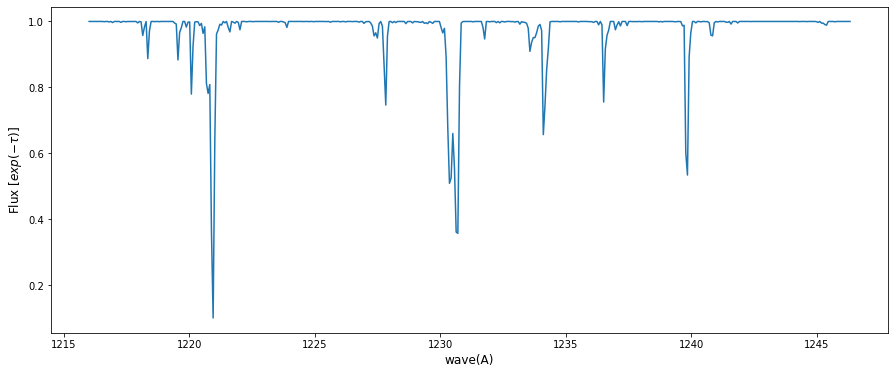

In [43]:
ax = plt.figure(figsize = (15,6))
plt.plot(wavelength,flux)
ax = plt.gca()
ax.set_xlabel('wave(A)',size = 12)
ax.set_ylabel('Flux [$exp(-\\tau)$]',size=12)
plt.show()

### smooth the spectrum
If the flux is very colsed to 1.0 , then we set the flux with the value 1.0 to avoid wasting time to fit components with low column density.

Text(0, 0.5, 'Flux [$exp(-\\tau)$]')

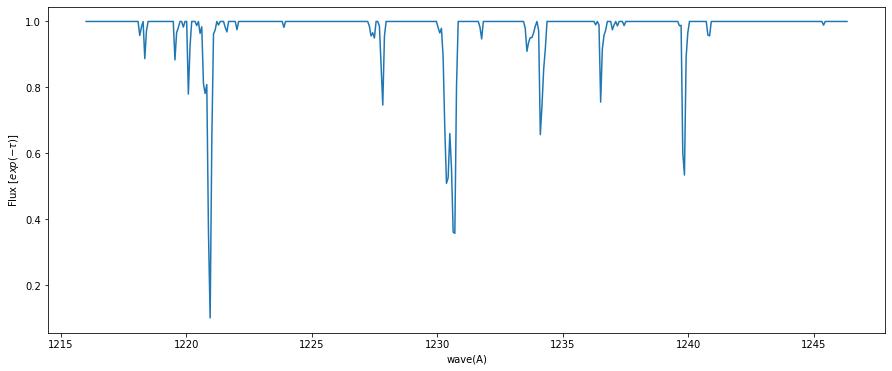

In [72]:
flux_copy = flux.copy()
for i in range(len(flux_copy)):
    if flux_copy[i]>=0.99:
        flux_copy[i] = 1
plt.figure(figsize = (15,6))
plt.plot(wavelength,flux_copy)
plt.xlabel('wave(A)')
plt.ylabel('Flux [$exp(-\\tau)$]')

#### Distinguish the possible absorbers

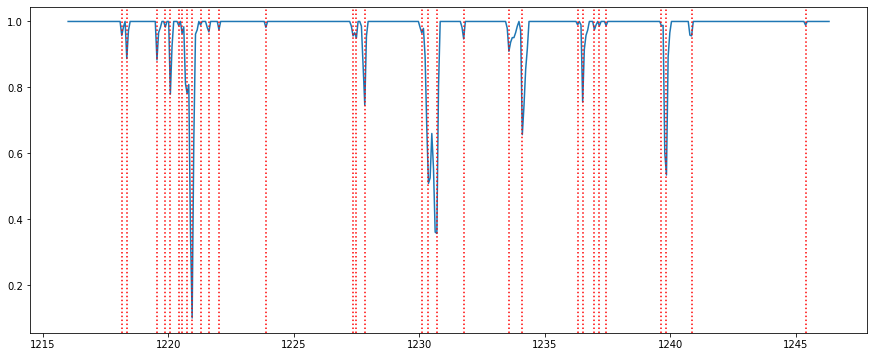

In [73]:
plt.figure(figsize = (15,6))
plt.plot(wavelength,flux_copy)
index = []
for j in range(1,len(wavelength)-1):
    if flux_copy[j+1] - flux_copy[j] > 0 and flux_copy[j-1]-flux_copy[j] > 0 :
            index.append(j)
            plt.axvline(x = wavelength[j],linestyle = ':',color = 'red')

#### Set the fitting parameter

In [74]:
delta_z = 5e-5
mod = Model(Abvoigt,prefix='n0_')
for i in range(1,len(index)):
    mod = mod * Model(Abvoigt,prefix='n'+str(i)+'_')

In [75]:
para = mod.make_params()
for i in range(len(index)):
    para['n'+str(i)+'_'+'lam'].value = 1216
    para['n'+str(i)+'_'+'fosc'].value = f_lya
    para['n'+str(i)+'_'+'gam'].value = 2
    para['n'+str(i)+'_'+'lam'].vary, para['n'+str(i)+'_'+'fosc'].vary, para['n'+str(i)+'_'+'gam'].vary = False, False, False
    para['n'+str(i)+'_'+'bpar'].value = 10
    para['n'+str(i)+'_'+'bpar'].min, para['n'+str(i)+'_'+'bpar'].max = 0,200
    para['n'+str(i)+'_'+'bpar'].brute_step = 0.01
    para['n'+str(i)+'_'+'logn'].value = 12
    para['n'+str(i)+'_'+'logn'].min, para['n'+str(i)+'_'+'logn'].max = 9, 18
    para['n'+str(i)+'_'+'logn'].brute_step = 0.01
    para['n'+str(i)+'_'+'z'].value = wavelength[index[i]]/1216-1
    para['n'+str(i)+'_'+'z'].min, para['n'+str(i)+'_'+'z'].max = wavelength[index[i]]/1216-1.001, wavelength[index[i]]/1216-0.009
    para['n'+str(i)+'_'+'z'].brute_step = delta_z

**Fit the spectrum**

In [76]:
out = mod.fit(flux_copy, para, x=wavelength, method='leastsq')

**Fitting results**

Text(0, 0.5, 'Flux [$exp(-\\tau)$]')

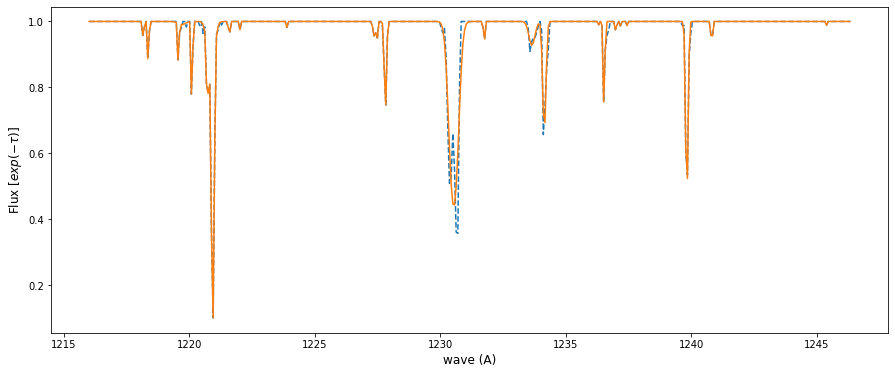

In [77]:
plt.figure(figsize = (15,6))
plt.plot(wavelength,flux_copy,'--')
plt.plot(wavelength,out.best_fit)
plt.xlabel('wave (A)',size = 12)
plt.ylabel('Flux [$exp(-\\tau)$]',size=12)

In [54]:
logn_fit = []
z_fit = []
for i in range(len(index)):
    logn_fit.append(out.best_values['n%i_logn' %i])
    z_fit.append(out.best_values['n%i_z' %i])

In [53]:
logn_fit

[11.934545927493705,
 12.321100546486914,
 12.410938140390513,
 11.800682198287927,
 12.720821659004715,
 10.273719109257637,
 13.06411082132042,
 13.604256671822057,
 13.058766196045404,
 12.621516068669404,
 11.846391926086786,
 11.239454446386365,
 11.184036345646172,
 11.861209436747155,
 12.085182423054484,
 12.771449945762516,
 10.78067501693686,
 13.786481754776794,
 12.407697917500744,
 12.00448727811185,
 12.599769837248411,
 13.052439470241222,
 10.954447308927028,
 12.65610555198995,
 11.687926735545563,
 11.065786228168326,
 11.037710272109775,
 10.165058956405371,
 13.183317434521701,
 12.08787448841069,
 10.9940057438343]

**Save the fitting result**

In [56]:
ii = 0
fitpath = 'data/fitdata/'
fitpara_name = fitpath + 'fitpara/fitpara_%i.csv' %ii
fitspec_name = fitpath + 'fitspec/fitspec_%i.csv' %ii

fitpara_file=pd.DataFrame(columns=[],data=[])
fitpara_file.to_csv(fitpara_name)
with open(fitpara_name,'w',encoding='utf-8') as file:
    file_writer = csv.writer(file)
    file_writer.writerow(['z_fit','logn'])
    file_writer.writerows(zip(z_fit,logn_fit))
file.close()

fitspec_file=pd.DataFrame(columns=[],data=[])
fitspec_file.to_csv(fitspec_name)
with open(fitspec_name,'w',encoding='utf-8') as file:
    file_writer = csv.writer(file)
    file_writer.writerow(['wave','flux'])
    file_writer.writerows(zip(wavelength,out.best_fit))
file.close()

**Test the saving result**

In [57]:
fitpara = pd.read_csv(fitpara_name)
fitpara.keys()

Index(['z_fit', 'logn'], dtype='object')

In [62]:
fitpara['logn'][0:5]

0    11.934546
1    12.321101
2    12.410938
3    11.800682
4    12.720822
Name: logn, dtype: float64

In [63]:
fitspec = pd.read_csv(fitspec_name)
fitspec.keys()

Index(['wave', 'flux'], dtype='object')

In [64]:
wave_fit = fitspec['wave']
flux_fit = fitspec['flux']

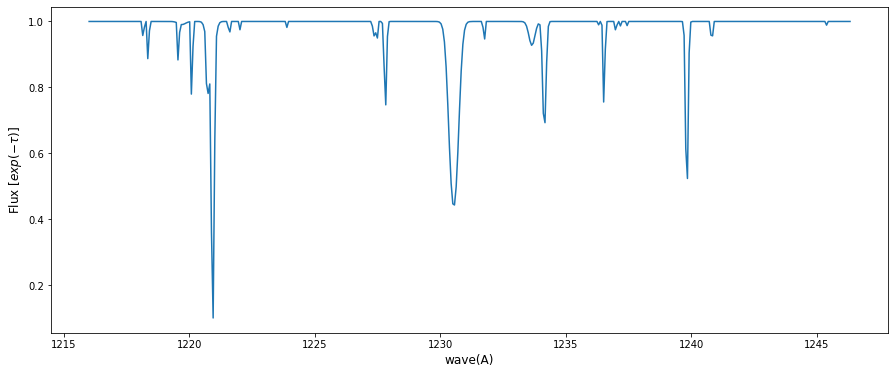

In [65]:
ax = plt.figure(figsize = (15,6))
plt.plot(wave_fit,flux_fit)
ax = plt.gca()
ax.set_xlabel('wave(A)',size = 12)
ax.set_ylabel('Flux [$exp(-\\tau)$]',size=12)
plt.show()